# Data Visualisation

In [1]:
import pandas as pd 
import glob 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
import os 
os.getcwd()

'/Users/julesbaudet/Documents/0. Cours/ENS/Deep Learning DIY/Projet final/DL_ens'

### Data Loading

In [3]:
filelist = glob.glob("/Users/julesbaudet/Documents/0. Cours/ENS/Deep Learning DIY/Projet final/ens_data/brave/*.csv")

# LINUS: Insert your glob.glob() here!  (but don't delete mine)

In [5]:
#pd.read_csv(filelist)
li = []

for filename in filelist:
    df = pd.read_csv(filename)
    li.append(df)
    break

frame = pd.concat(li, axis=0, ignore_index=True)

In [6]:
display(frame.head())
print(f'the data contains {frame.shape[0]} transactions')

,from_address,to_address,value,transaction_hash,log_index,block_hash,block_number,block_timestamp,unix_block_timestamp,forged
0,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,0xf142f26d1cac4ba8a6e6d7974d243eda2fe5f4f9,97.444845,0x01161737125d0308cd9b77949d29135ad7c4db332ec1...,69,0x302d44c68cf022ef74a1cc9eaba802fc859fbf10d789...,4252144,2017-09-08T15:47:18.000Z,1504885638,False
1,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x2733f4032b07ae40b00564cd7838c69d09e250a4,3428.070585,0x690227ce2c254e23bfd4e236117b7c0fb74961fbc5f9...,2,0x73f0cd4de834f9b5ca101405bf84a1581bbce08123e5...,4253534,2017-09-09T00:57:17.000Z,1504918637,False
2,0x73295d3c0ca46113ca226222c81c79adabf9f391,0x246a0810f2c18a68a979d07d28cda04fd95596de,169.778163,0x04a6b26a597dbbfa6513da07744c1cf3dd7021993722...,13,0x5e6a81215c16beefcbf0daa79034ad5dbc719ddc9a96...,4258823,2017-09-10T13:09:12.000Z,1505048952,False
3,0x1986607d10c7539e81e64c18c1b73ccf133cfd27,0x3e19c3544a05e5af9d81af9aec8ab39588aa3636,50.000000,0x5daa3810a61c326cbf2d2844b02e368ec005fa145a95...,20,0xf568503537a6fa70af2a75662b900791afd45bf3a63b...,4252266,2017-09-08T16:37:38.000Z,1504888658,False
4,0x73295d3c0ca46113ca226222c81c79adabf9f391,0xfab38571f4bffbf11f52ee9cbe309f018423f088,5087.291153,0x2d8017a2fb71767949809e99287a079d2db26877543d...,30,0xf91976261d03074011097685705debf1f97dac3ab14a...,4256714,2017-09-09T22:30:32.000Z,1504996232,False


the data contains 269578 transactions


In [7]:
frame.groupby(by='forged').count()

,from_address,to_address,value,transaction_hash,log_index,block_hash,block_number,block_timestamp,unix_block_timestamp
forged,,,,,,,,,
False,269558,269558,269558,269558,269558,269558,269558,269558,269558
True,20,20,20,20,20,20,20,20,20


## Data preparation

The data is composed of 269578 transactions, which have attributes: 
- from_address: address from which the transaction originated
- to_address: address to which the transaction was sent 
- value: amount of the transaction
- transaction_hash, log_index: couple of identifiants that uniquely identifies each transaction 
- block_hash: block identifier, a block is a list of transactions added at once to the blockchain 
- block_number: number of the block, the smaller the older
- block_timestamp: date at which the block was created
- unix_block_timestamp: date at which the block was created in unix time
- forged: True if the transaction was forged. There are 20 such transactions.

We start by: 
- removing forged transactions
- keeping only one unit of time, unix_block_timestamp

In [8]:
# is it the right thing to do? maybe keep them all, maybe delete all addresses involved in forged transactions 
frame = frame.loc[frame['forged']==False]
frame = frame.drop(columns = ['block_number','block_timestamp','forged'])

# we sort the transactions per date
frame = frame.sort_values('unix_block_timestamp')

We add two columns: _send_is_id_ (respectively _receive_is_id_ ) to indicate whether the sending (resp. receiving) address was identified as an exchange. 

In [11]:
# import the known exchange list 
exch_labels = pd.read_csv('/Users/julesbaudet/Documents/0. Cours/ENS/Deep Learning DIY/Projet final/ens_data/exchanges_encoded.csv', 
                          delimiter=';', names  = ['address','label']).set_index('address')

labels = exch_labels.to_dict()['label'] # keys = addresses, values = name of the exchange
labels2int = dict(zip(labels.values(),[i for i in range(len(labels))])) # keys = addresses, values = name of the exchange
address2int = {k:labels2int[labels[k]] for k in labels.keys()}

known_addresses = list(labels.keys()) # list of all the addresses that were identified as exchanges

# add it to the dataframe
# frame['labels'] = [labels2int[labels[a]] if (a in labels.keys()) else np.nan for a in frame['from_address'].values]

In [12]:
frame['send_is_id'] = frame['from_address'].isin(known_addresses).astype(int)
frame['receive_is_id'] = frame['to_address'].isin(known_addresses).astype(int)

## Descriptive Statistics

In [13]:
#Counts the number of unique entries of 'from adress', i.e. the number of senders 
print(f'there are {frame["from_address"].nunique()} addresses sending transactions')

#Counts the number of unique entries of 'to adress', i.e. the number of receivers
print(f'there are {frame["to_address"].nunique()} addresses receiving transactions')

#Average value of transaction
print(f'the average value of a transaction is {frame["value"].mean()}')

addresses = pd.concat((frame["from_address"],frame["to_address"])).unique()
print(f'in total there are {addresses.shape[0]} addresses')

print(f'in total {len(known_addresses)} addresses were identified as exchanges')

there are 99368 addresses sending transactions
there are 135994 addresses receiving transactions
the average value of a transaction is 14706.48084818199
in total there are 213758 addresses
in total 279 addresses were identified as exchanges


There are more addresses _receiving_ cryptocurrency than _sending_.

In [14]:
frame['value'].describe()

count    2.695580e+05
mean     1.470648e+04
std      3.320468e+05
min      1.000000e-18
25%      5.364811e+01
50%      4.421797e+02
75%      3.177169e+03
max      6.438847e+07
Name: value, dtype: float64

In [19]:
exch = frame.loc[frame['send_is_id'] == 1]
non_exch = frame.loc[frame['send_is_id'] == 0]

print('senders identified as exchanges')
display(exch['value'].describe())
print('senders not identified as exchanges')
display(non_exch['value'].describe())

m = exch.groupby(by = 'from_address').count()['value'].mean()
print(f'in average, each exchange sent {round(m,3)} transactions')
m2 = non_exch.groupby(by = 'from_address').count()['value'].mean()
print(f'in average, each non exchange sent {round(m2,3)} transactions')

senders identified as exchanges


count    3.943500e+04
mean     2.066996e+04
std      3.962182e+05
min      8.559000e-05
25%      2.009900e+02
50%      1.481791e+03
75%      1.000110e+04
max      5.066689e+07
Name: value, dtype: float64

senders not identified as exchanges


count    2.301230e+05
mean     1.368455e+04
std      3.197499e+05
min      1.000000e-18
25%      4.228777e+01
50%      3.419667e+02
75%      2.452967e+03
max      6.438847e+07
Name: value, dtype: float64

in average, each exchange sent 532.905 transactions
in average, each non exchange sent 2.318 transactions


In [20]:
exch = frame.loc[frame['receive_is_id'] == 1]
non_exch = frame.loc[frame['receive_is_id'] == 0]

print('receivers identified as exchanges')
display(exch['value'].describe())
print('receivers not identified as exchanges')
display(non_exch['value'].describe())

m = exch.groupby(by = 'to_address').count()['value'].mean()
print(f'in average, each exchange received {round(m,3)} transactions')
m2 = non_exch.groupby(by = 'to_address').count()['value'].mean()
print(f'in average, each non exchange received {round(m2,3)} transactions')

receivers identified as exchanges


count    2.379800e+04
mean     3.615020e+04
std      5.145412e+05
min      1.051500e-14
25%      6.715733e+02
50%      3.408600e+03
75%      1.646992e+04
max      5.066689e+07
Name: value, dtype: float64

receivers not identified as exchanges


count    2.457600e+05
mean     1.262999e+04
std      3.086204e+05
min      1.000000e-18
25%      4.753094e+01
50%      3.443044e+02
75%      2.477112e+03
max      6.438847e+07
Name: value, dtype: float64

in average, each exchange received 293.802 transactions
in average, each non exchange received 1.808 transactions


In [21]:
exch = frame.loc[(frame['send_is_id'] == 1)|(frame['receive_is_id'] == 1)]
non_exch = frame.loc[(frame['send_is_id'] == 0)|(frame['receive_is_id'] == 0)]

In [23]:
a = exch[['from_address','unix_block_timestamp']].reset_index()
b = exch[['to_address','unix_block_timestamp']]
all_transactions_exch = pd.concat([a.rename(columns={'from_address': 'address'}), b.rename(columns={'to_address': 'address'})])
all_transactions_exch = all_transactions_exch.loc[all_transactions_exch['address'].isin(known_addresses)]

m = all_transactions_exch.groupby(by='address')['unix_block_timestamp'].count().mean()
print(f'on average, exchange addresses are active during {round(m,3)} blocks')

a = non_exch[['from_address','unix_block_timestamp']].reset_index()
b = non_exch[['to_address','unix_block_timestamp']]
all_transactions_nexch = pd.concat([a.rename(columns={'from_address': 'address'}), b.rename(columns={'to_address': 'address'})])
all_transactions_nexch = all_transactions_nexch.loc[~all_transactions_nexch['address'].isin(known_addresses)]

m = all_transactions_nexch.groupby(by='address')['unix_block_timestamp'].count().mean()
print(f'on average, exchange addresses are active during {round(m,3)} blocks')

on average, exchange addresses are active during 761.843 blocks
on average, exchange addresses are active during 2.227 blocks


| | Exchange | Non-Exchange |
| --- | --- | --- |
|total # transactions sent | 39 435 | 230 123|
|total # transactions received | 23 798 | 245 760 |
|Avg Amount sent | 20 670.0 | 13 684.6 |
|Avg Amount received | 36 150.20 | 12 630.0 |
|Avg # active periods | 761.8 | 2.2 |
|Avg # transactions sent | 532.9 | 2.3 |
|Avg # transactions received | 293.8 | 1.8 |
|Avg # transactions in which involved | 826.7 | 4.1|


This table tends to indicate that addresses owned by exchanges are active much longer. 
Moreover, it seems that transactions involving exchanges are larger and that addresses owned by exchanges are involved in more transactions.

We now look at histograms for more granurality. 

In [149]:
def distrib_plot(frames, cat, sent = True, log = True):
    '''
    cat: string corresponding to a column of frame 
    
    plots the distribution of transactions per cat
    '''
    #Determine top senders 
    n = len(frames)
    f,ax=plt.subplots(1, n, figsize=(10*n,7))
    for i in range(n):
        if sent: 
            unique_senders = frames[i]["from_address"].unique()
            grouped_senders = frames[i].groupby(by="from_address").sum()
        
        else:
            unique_senders = frames[i]["to_address"].unique()
            grouped_senders = frames[i].groupby(by="to_address").sum()

        ax[i].hist(grouped_senders[cat], bins=200, weights=np.ones(grouped_senders.shape[0]) / grouped_senders.shape[0])
        ax[i].set_ylabel('# of transactions (log scale)')
        ax[i].set_xlabel(cat)
        #plt.xscale("log")
        status = 'sent' if sent else 'received'
        ax[i].set_title(f'Distribution of total amount of cryptocurrency {status} per {cat}')
        if log: 
            ax[i].set_yscale("log")

In [143]:
#distrib_plot(frame, 'value')

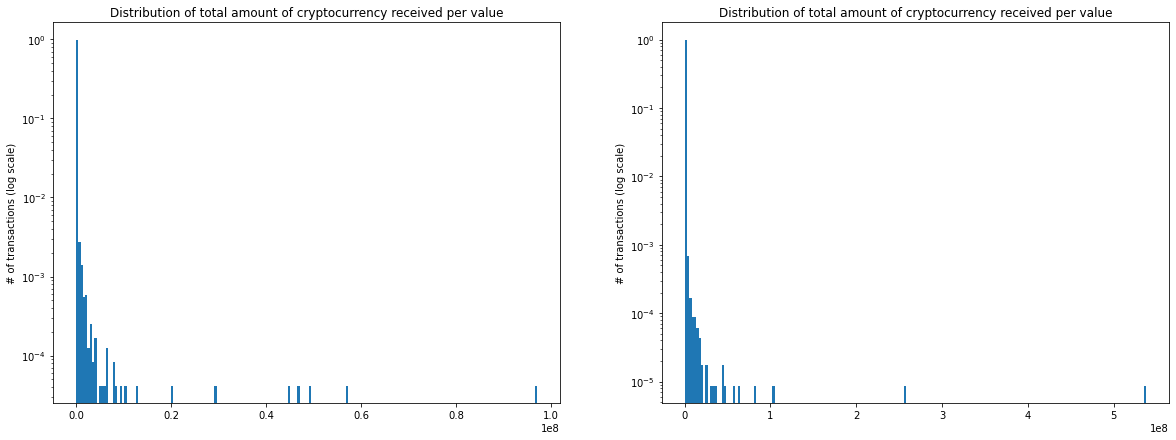

In [147]:
distrib_plot([frame.loc[frame['send_is_id']==1], frame.loc[frame['send_is_id']==0]],'value',sent = False)
print('left: exchange, right: non exchange')

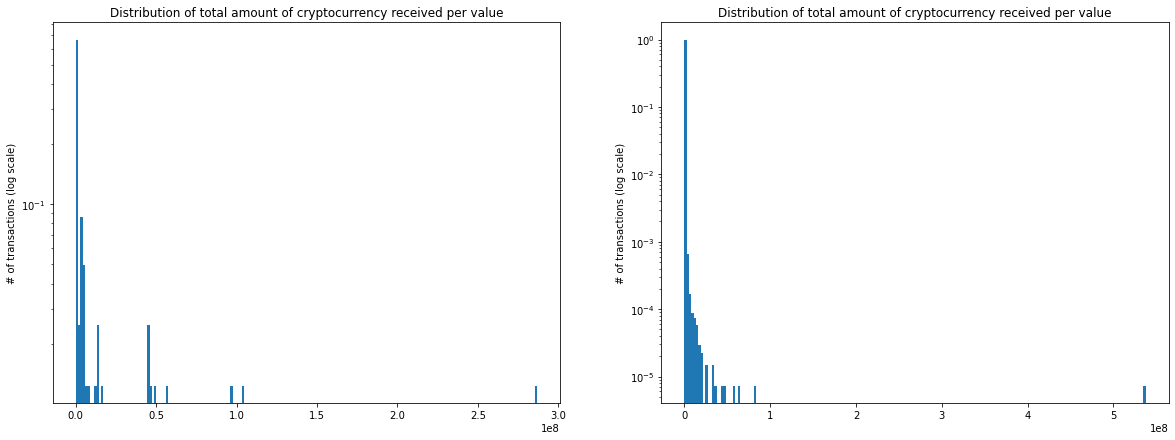

In [148]:
distrib_plot([frame.loc[frame['receive_is_id']==1], frame.loc[frame['receive_is_id']==0]],'value',sent = False)
print('left: exchange, right: non exchange')

first plot = exchanges, second = non exchanges


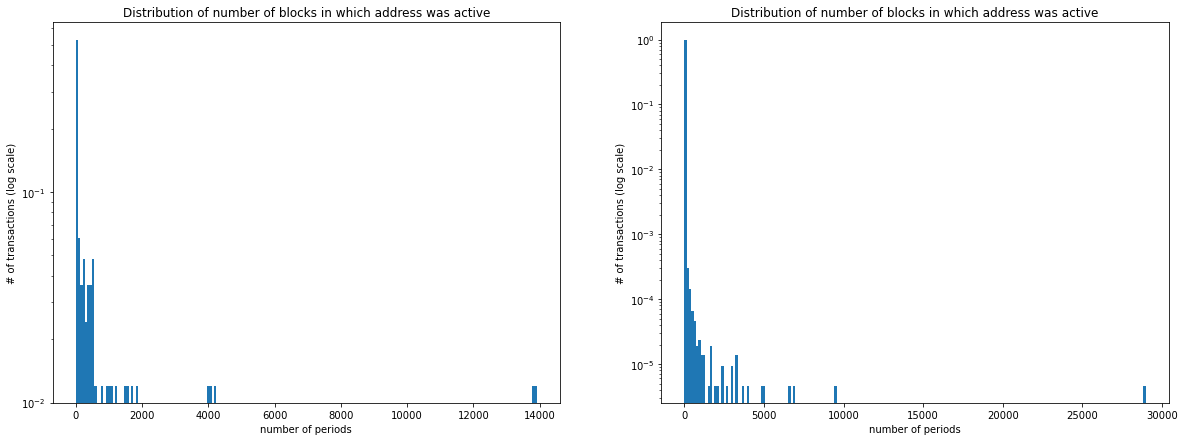

In [132]:
print('first plot = exchanges, second = non exchanges')
l = [all_transactions_exch.groupby(by='address').nunique(), all_transactions_nexch.groupby(by='address').nunique()]
f,ax=plt.subplots(1,2,figsize=(20,7))
for i in range(2):
    grouped_senders = l[i]
    ax[i].hist(grouped_senders['unix_block_timestamp'], bins=200,  weights=np.ones(grouped_senders.shape[0]) / grouped_senders.shape[0])
    ax[i].set_ylabel('# of transactions (log scale)')
    ax[i].set_xlabel('number of periods')
    ax[i].set_yscale("log")
    ax[i].set_title('Distribution of number of blocks in which address was active')
    # distrib_plot(frame.loc[frame['value'] <= 20000],'value')

In [25]:
def graph_plot(frame, t_min, t_max, savefig=False):
    '''
    function that plots the graph (V=addresses, E=transactions) for transactions between t_min and t_max
    '''
    gframe = frame.loc[(frame['unix_block_timestamp'] >= t_min) & (frame['unix_block_timestamp'] <= t_max)]
    
    # create edges weighted by amount of transaction (i.e. 'value' in df)
    edgelist = [(a,b,w) for a,b,w in zip(gframe.from_address, gframe.to_address, frame.value)]
    G = nx.DiGraph()
    G.add_weighted_edges_from(edgelist) # edgeliste[:100]
    
    # assign each node value -1 if not identified, else integer exchange identifier
    val = {i:address2int[i] if (i in address2int.keys()) else -1 for i in G.nodes}
    nx.set_node_attributes(G, val,'val')
    
    f,ax=plt.subplots(figsize=(20,20))
    
    nx.draw_circular(G, node_color = list(nx.get_node_attributes(G,'val').values()), cmap = plt.cm.get_cmap('rainbow'),
                     alpha = 0.4, node_size=[v * 100 for v in dict(G.degree).values()])#, pos)
    
    if savefig:
        plt.savefig(f"graph_{np.datetime64('now').astype('str')}.pdf")

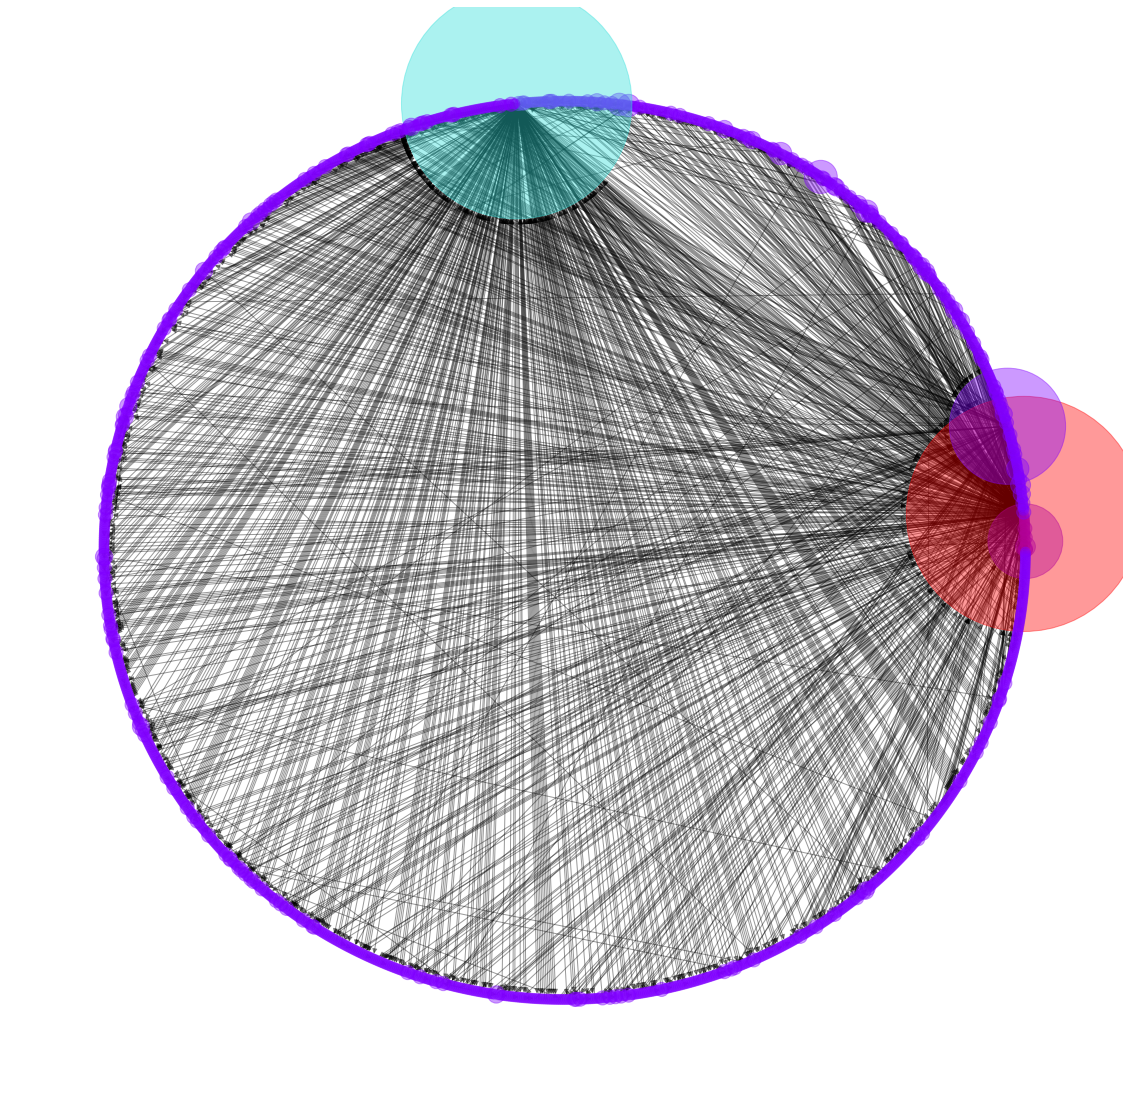

In [27]:
graph_plot(frame, frame.iloc[0]['unix_block_timestamp'],frame.iloc[2000]['unix_block_timestamp'])

In [31]:
# create frame with only transactions involving identified exchanges 
frame_id = frame.loc[(frame['from_address'].isin(known_addresses)) | (frame['to_address'].isin(known_addresses))]

print(f'there are {frame_id.size} transactions involving an identified exchange, that is {(100*frame_id.size/frame.size).round(2)}% of all transactions')

there are 559134 transactions involving an identified exchange, that is 23.05% of all transactions


In [153]:
#test  = frame.loc[frame['from_address'].isin(['0x008932be50098089c6a075d35f4b5182ee549f8a', '0x0093e5f2a850268c0ca3093c7ea53731296487eb', 
#                                      '0x03bdf69b1322d623836afbd27679a1c0afa067e9', '0x05f51aab068caa6ab7eeb672f88c180f67f17ec7',
#                                      '0xfe9e8709d3215310075d67e3ed32a380ccf451c8','0x0c6c34cdd915845376fb5407e0895196c9dd4eec']) ]

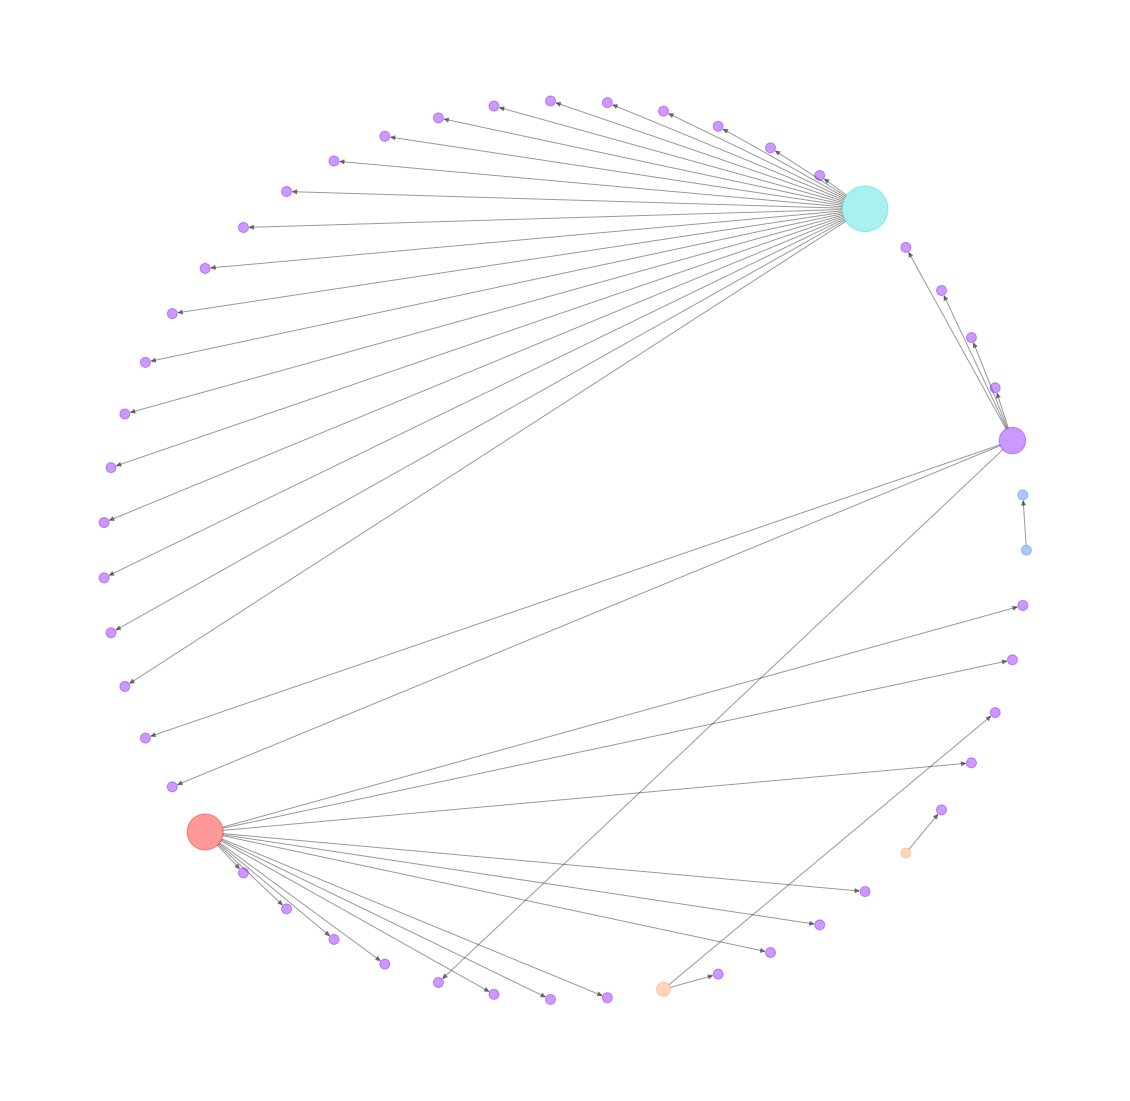

In [154]:
# graph_plot(test, test.iloc[0]['unix_block_timestamp'],test.iloc[-1]['unix_block_timestamp'])

In [29]:
# gtest = frame.groupby(by="from_address").count()
# gtest.loc[(gtest.index.isin(known_addresses))].iloc[:30]

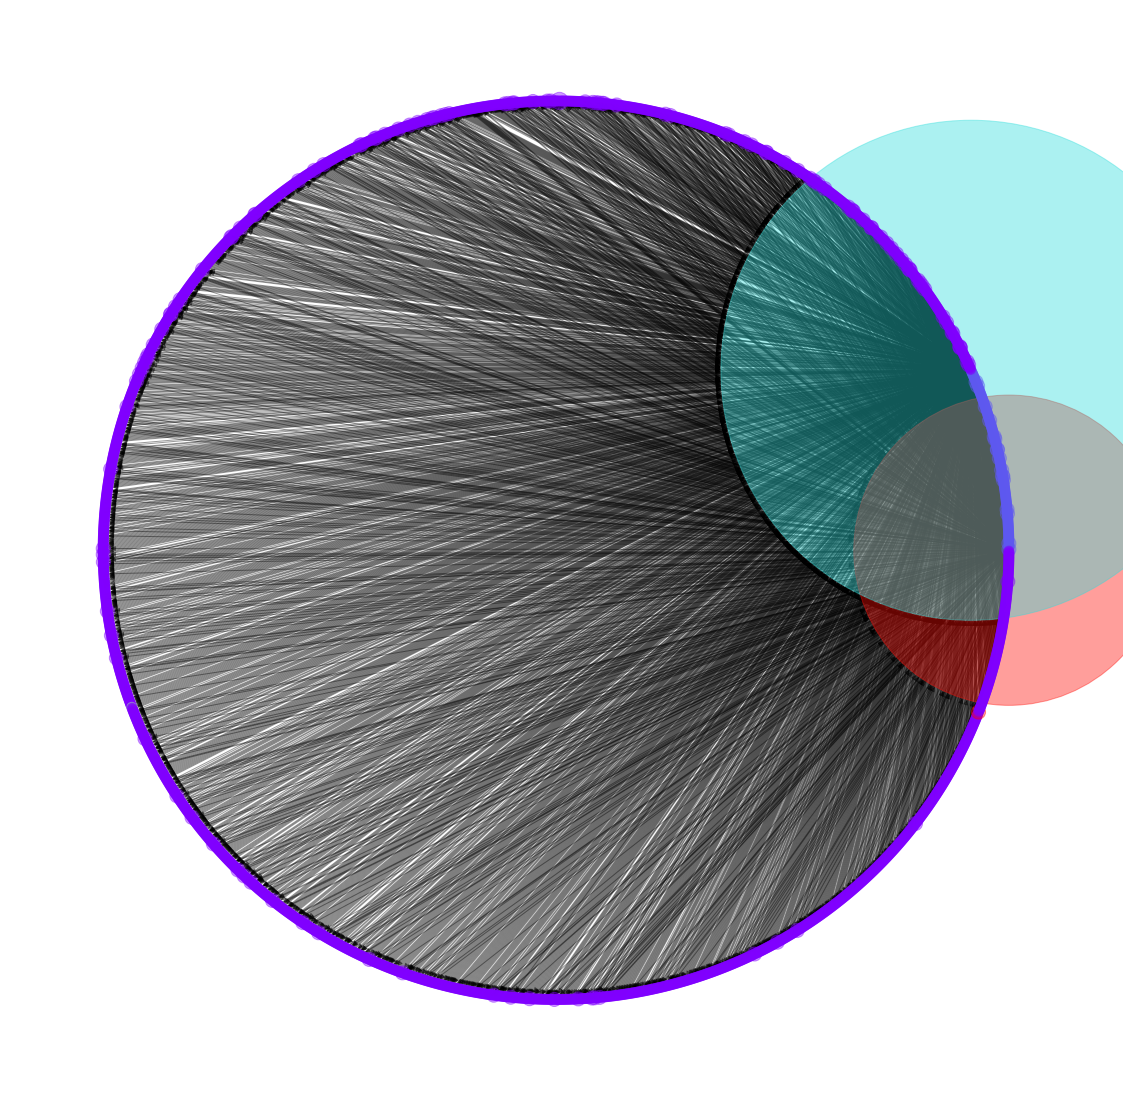

In [32]:
graph_plot(frame_id, frame_id.iloc[0]['unix_block_timestamp'],frame_id.iloc[5000]['unix_block_timestamp'])

Text(0.5, 0, '# of transactions')

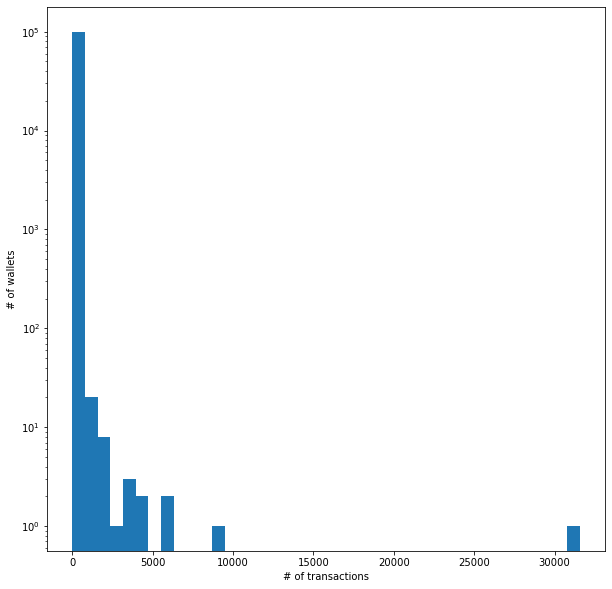

In [155]:
#Histogram for the number of transactions (sent) per wallet

count_frame = frame.groupby(by="from_address").count()
f,ax=plt.subplots(figsize=(10,10))
plt.hist(count_frame.to_address,bins=40)
plt.yscale("log")
plt.ylabel("# of wallets")
plt.xlabel("# of transactions")

In [25]:
eth_data=pd.read_csv("/Users/linusbleistein/Desktop/etherumdata.csv",sep=';')

eth_data["date"] = eth_data["date"].str[:10]


print(frame["block_timestamp"].min())
print(frame["block_timestamp"].max())

eth_data_aux = eth_data[eth_data.date>=frame["block_timestamp"].min()]
eth_data_correct_time = eth_data_aux[eth_data_aux.date<=frame["block_timestamp"].max()]


eth_data_correct_time

FileNotFoundError: [Errno 2] No such file or directory: '/Users/linusbleistein/Desktop/etherumdata.csv'

In [ ]:
frame_copy = frame
frame_copy["block_timestamp"] = frame_copy["block_timestamp"].str[:10]
frame_copy=frame_copy.groupby(by="block_timestamp").count()



f,ax=plt.subplots(figsize=(20,10))
plt.plot(frame_copy.from_address)
plt.plot(eth_data_correct_time.high)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
#plt.yscale("log")
plt.ylabel("# of transactions (log scale)")
plt.xlabel("Time")
plt.savefig("ntransac.pdf")


In [13]:
# frame["block_timestamp"][0:10]
#edgeliste = [(a,b) for a,b in zip(frame.from_address, frame.to_address)]
#G = nx.from_edgelist(edgeliste[:500], create_using=nx.DiGraph) # edgeliste[:100]
#f,ax=plt.subplots(figsize=(20,20))
#nx.draw_spring(G)
#edgeliste = [(a,b,w) for a,b,w in zip(frame.from_address, frame.to_address, frame.value)]
#G_w = nx.DiGraph()
#G_w.add_weighted_edges_from(edgeliste[:500]) # edgeliste[:100]
#f,ax=plt.subplots(figsize=(20,20))
#nx.draw_spring(G)# frame["block_timestamp"][0:10]

In [60]:
# gframe = frame.iloc[:70]
# edgelist = [(a,b,w) for a,b,w in zip(gframe.from_address, gframe.to_address, frame.value)]
# G = nx.DiGraph()
# G.add_weighted_edges_from(edgelist) # edgeliste[:100]
# 
# val = {i:address2label[i] if (i in address2label.keys()) else -1 for i in G.nodes}
# nx.set_node_attributes(G, val,'val')
# 
# f,ax=plt.subplots(figsize=(20,20))
# nx.draw_spring(G, node_color = list(nx.get_node_attributes(G,'val').values()), cmap = plt.cm.get_cmap('rainbow'))#, pos)

In [71]:
# frame['block_timestamp'] = pd.to_datetime(frame['block_timestamp'])
# frame = frame.sort_values('block_timestamp')

#frame['block_timestamp'] = pd.to_numeric(frame['block_timestamp'])
#frame['block_timestamp'] = frame['block_timestamp'] - frame['block_timestamp'].min()